In [31]:
import pandas as pd
import networkx as nx
from modules import ps
import numpy as np
import sys
import functions
import utils
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import umap


In [7]:
congresses= ['095', '096', '097','098', '099', '100', '101', '102', '103','104', '105', '106', '107','108', '109', '110', '111', '112','113', '114', '115', '116','117','118']

## Polarization on the nominate score

## Opinions distribution

In [43]:
def analyze_polarization_across_congresses(congresses, data_path, output_path, suffix, edges,h,
                               methods=["pca", "mds", "umap"]):
    """
    Calculates and compares polarization across congresses using dimensionality reduction and NOMINATE scores.
    Uses pre-existing network edge lists created by construct_congress_network().
    
    Parameters:
    -----------
    congresses : list
        List of congress numbers (e.g., ['111', '112', '113'])
    data_path : str
        Path to the data directory
    output_path : str
        Path to save output files
    methods : list
        List of dimensionality reduction methods to use: 'pca', 'mds', 'umap'
        
    Returns:
    --------
    dict
        Dictionary containing polarization scores for each congress and method
    """
    
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Dictionary to store polarization scores for each congress
    polarization_results = {}
    
    # Process each congress
    for congress in congresses:
        print(f"\nProcessing {congress}th Congress...")
        congress_polarization = {}
        
        try:
            # Step 1: Load the edge list for the network
            edge_file = f"{data_path}/{h}{congress}_{suffix}_{edges}.csv"
            edge_df = pd.read_csv(edge_file)
            print(f"Loaded edge list for {congress}th Congress with {len(edge_df)} edges")
            
            # Clean up edge data - ensure numeric values
            edge_df = edge_df[pd.to_numeric(edge_df['Source'], errors='coerce').notna()]
            edge_df = edge_df[pd.to_numeric(edge_df['Target'], errors='coerce').notna()]
            
            # Convert to numeric and create graph
            edge_df['Source'] = edge_df['Source'].astype(int)
            edge_df['Target'] = edge_df['Target'].astype(int)
            G = nx.from_pandas_edgelist(edge_df, 'Source', 'Target')
            print(f"Created network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
            
            # Step 2: Load the member data with NOMINATE scores
            members_file = f"./data/USA/raw/H{congress}_members.csv"
            members_df = pd.read_csv(members_file)
            members_df = members_df.drop_duplicates(subset=['icpsr'])
            members_df['icpsr'] = members_df['icpsr'].astype(int)
            print(f"Loaded {len(members_df)} members for {congress}th Congress")
            
            # Step 3: Calculate polarization using NOMINATE scores
            if 'nominate_dim1' in members_df.columns:
                # Create a dictionary of NOMINATE scores
                nominate_opinions = dict(zip(members_df['icpsr'], members_df['nominate_dim1']))
                
                # Filter for nodes in the graph and valid values
                nominate_opinions = {k: v for k, v in nominate_opinions.items() 
                                   if k in G.nodes and not pd.isna(v)}
                

                        
                        # Calculate polarization
                pol_score = ps.ge(nominate_opinions, {}, G)
                congress_polarization['nominate'] = pol_score
                print(f"NOMINATE polarization: {pol_score:.4f}")
            
            # Step 4: Load the voting data for dimensionality reduction
            votes_file = f"./data/USA/Filtered/H{congress}_filtered_USA_votes.csv"
            votes_df = pd.read_csv(votes_file)
            print(f"Loaded {len(votes_df)} votes for {congress}th Congress")
            
            # Step 5: Create a sparse matrix of votes
            reps = votes_df['icpsr'].unique()
            roll_calls = votes_df['rollnumber'].unique()
            
            rep_to_idx = {rep: i for i, rep in enumerate(reps)}
            roll_to_idx = {roll: j for j, roll in enumerate(roll_calls)}
            
            row_indices = []
            col_indices = []
            values = []
            
            for _, row in votes_df.iterrows():
                rep_idx = rep_to_idx[row['icpsr']]
                roll_idx = roll_to_idx[row['rollnumber']]
                row_indices.append(rep_idx)
                col_indices.append(roll_idx)
                values.append(row['cast_code'])
            
            # Create the sparse matrix
            sparse_matrix = csr_matrix((values, (row_indices, col_indices)), 
                                      shape=(len(reps), len(roll_calls)))
            
            # Create a DataFrame linking sparse matrix rows to representative IDs
            sparse_df = pd.DataFrame({'icpsr': reps})
            
            # Step 6: Perform dimensionality reduction for each method
            if 'pca' in methods:
                print("Performing PCA...")
                pca = PCA(n_components=2)
                pca_result = pca.fit_transform(sparse_matrix.toarray())
                sparse_df['pca_1'] = pca_result[:, 0]
                sparse_df['pca_2'] = pca_result[:, 1]
                
                # Calculate polarization using PCA
                sparse_df['icpsr'] = sparse_df['icpsr'].astype(int)
                pca_opinions = dict(zip(sparse_df['icpsr'], sparse_df['pca_1']))
                
                # Filter for nodes in the graph and valid values
                pca_opinions = {k: v for k, v in pca_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if pca_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(pca_opinions.values())
                    max_val = max(pca_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        pca_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in pca_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(pca_opinions_norm, {}, G)
                        congress_polarization['pca'] = pol_score
                        print(f"PCA polarization: {pol_score:.4f}")
            
            if 'mds' in methods:
                print("Performing MDS...")
                mds = MDS(n_components=2, random_state=42, n_jobs=-1)
                mds_result = mds.fit_transform(sparse_matrix.toarray())
                sparse_df['mds_1'] = mds_result[:, 0]
                sparse_df['mds_2'] = mds_result[:, 1]
                
                # Calculate polarization using MDS
                mds_opinions = dict(zip(sparse_df['icpsr'], sparse_df['mds_1']))
                
                # Filter for nodes in the graph and valid values
                mds_opinions = {k: v for k, v in mds_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if mds_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(mds_opinions.values())
                    max_val = max(mds_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        mds_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in mds_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(mds_opinions_norm, {}, G)
                        congress_polarization['mds'] = pol_score
                        print(f"MDS polarization: {pol_score:.4f}")
            
            if 'umap' in methods:
                print("Performing UMAP...")
                reducer = umap.UMAP(n_components=2, random_state=42)
                umap_result = reducer.fit_transform(sparse_matrix.toarray())
                sparse_df['umap_1'] = umap_result[:, 0]
                sparse_df['umap_2'] = umap_result[:, 1]
                
                # Calculate polarization using UMAP
                umap_opinions = dict(zip(sparse_df['icpsr'], sparse_df['umap_1']))
                
                # Filter for nodes in the graph and valid values
                umap_opinions = {k: v for k, v in umap_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if umap_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(umap_opinions.values())
                    max_val = max(umap_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        umap_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in umap_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(umap_opinions_norm, {}, G)
                        congress_polarization['umap'] = pol_score
                        print(f"UMAP polarization: {pol_score:.4f}")
            
            # Save results for this congress
            polarization_results[congress] = congress_polarization
            
            # Save the dimensionality reduction results for future use
            sparse_df.to_csv(f"{output_path}H{congress}_dimensionality_reduction.csv", index=False)
            
        except Exception as e:
            print(f"Error processing {congress}th Congress: {e}")
    pol_df = pd.DataFrame.from_dict(polarization_results, orient='index')
    pol_df = pol_df.reset_index().rename(columns={'index': 'congress'})
    pol_df['congress_num'] = pol_df['congress'].astype(int)
    pol_df = pol_df.sort_values('congress_num').set_index('congress')
    pol_df = pol_df.drop('congress_num', axis=1)
    pol_df.to_csv(f"{output_path}polarization_scores.csv")
    print(f"Saved polarization data to {output_path}polarization_scores.csv")
    
    return polarization_results



In [ ]:
results = analyze_polarization_across_congresses(congresses, data_path="./data/USA/avg_party/", output_path="data/USA/avg_party/results/", edges="edgelist", suffix="USA")

In [37]:
results = analyze_polarization_across_congresses(congresses, data_path="./data/USA/intra_inter_party/", output_path="data/USA/intra_inter_party/results/",, )


Processing 095th Congress...
Error processing 095th Congress: [Errno 2] No such file or directory: './data/USA/intra_inter_party/H095_USA_edgelist.csv'

Processing 096th Congress...
Error processing 096th Congress: [Errno 2] No such file or directory: './data/USA/intra_inter_party/H096_USA_edgelist.csv'

Processing 097th Congress...
Error processing 097th Congress: [Errno 2] No such file or directory: './data/USA/intra_inter_party/H097_USA_edgelist.csv'

Processing 098th Congress...
Error processing 098th Congress: [Errno 2] No such file or directory: './data/USA/intra_inter_party/H098_USA_edgelist.csv'

Processing 099th Congress...
Error processing 099th Congress: [Errno 2] No such file or directory: './data/USA/intra_inter_party/H099_USA_edgelist.csv'

Processing 100th Congress...
Error processing 100th Congress: [Errno 2] No such file or directory: './data/USA/intra_inter_party/H100_USA_edgelist.csv'

Processing 101th Congress...
Error processing 101th Congress: [Errno 2] No such f

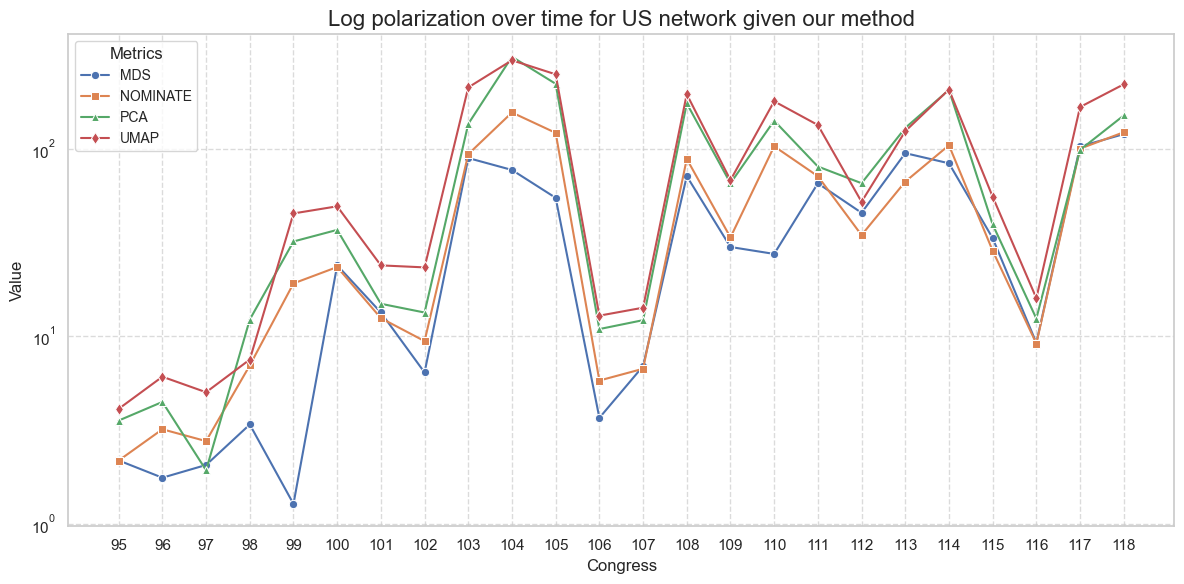

In [36]:

results = pd.read_csv("data/USA/avg_party/results/polarization_scores.csv")
records = []
for congress, metrics in results.items():
    record = {'congress': congress}
    record.update(metrics)
    records.append(record)

# Create DataFrame and handle missing values
df = pd.DataFrame(records)
df = df.sort_values('congress')
df_transposed = df.set_index(df.columns[0]).T
#df_transposed.pop('congress')
df_transposed
# Assuming df_transposed is your DataFrame with columns: congress, mds, nominate, pca, umap
# and congress is the column to be used as x-axis

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the line plot
sns.lineplot(data=df_transposed, x='congress', y='mds', marker='o', label='MDS')
sns.lineplot(data=df_transposed, x='congress', y='nominate', marker='s', label='NOMINATE')
sns.lineplot(data=df_transposed, x='congress', y='pca', marker='^', label='PCA')
sns.lineplot(data=df_transposed, x='congress', y='umap', marker='d', label='UMAP')




# Customize the plot
plt.title('Log polarization over time for US network given our method', fontsize=16)
plt.xlabel('Congress', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Metrics', fontsize=10)
plt.yscale('log')
# Make sure x-axis shows integer values for Congress
plt.xticks(df_transposed['congress'])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()
plt.savefig("./images/polarization_scores/US_polarization_our_log.png", dpi=300)
# Show the plot
plt.show()


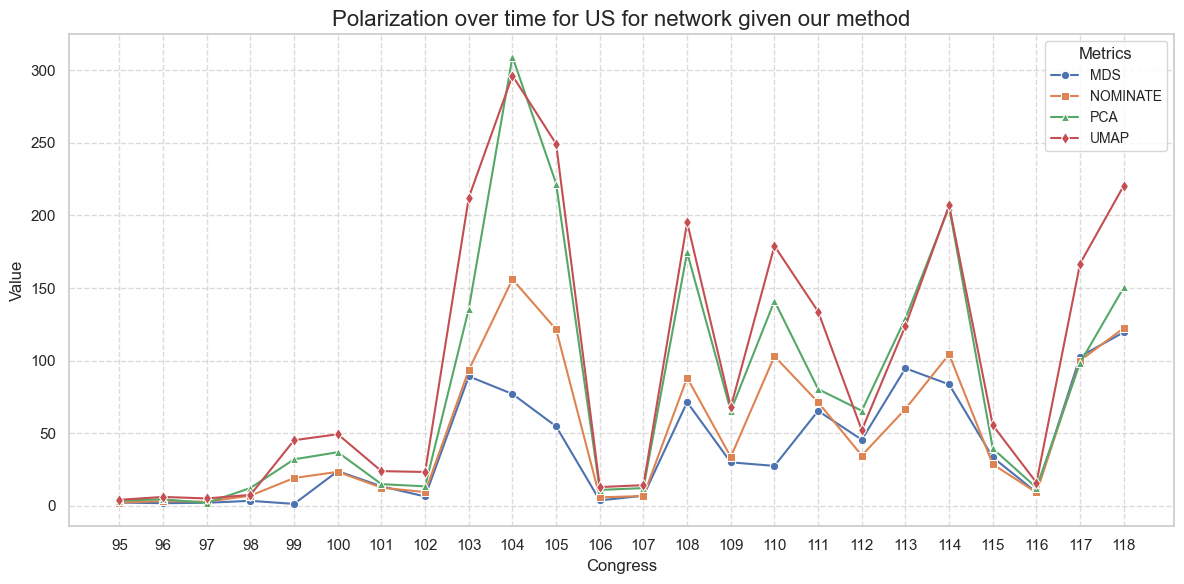

In [34]:

results = pd.read_csv("data/USA/avg_party/results/polarization_scores.csv")
records = []
for congress, metrics in results.items():
    record = {'congress': congress}
    record.update(metrics)
    records.append(record)

# Create DataFrame and handle missing values
df = pd.DataFrame(records)
df = df.sort_values('congress')
df_transposed = df.set_index(df.columns[0]).T
#df_transposed.pop('congress')
df_transposed
# Assuming df_transposed is your DataFrame with columns: congress, mds, nominate, pca, umap
# and congress is the column to be used as x-axis

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the line plot
sns.lineplot(data=df_transposed, x='congress', y='mds', marker='o', label='MDS')
sns.lineplot(data=df_transposed, x='congress', y='nominate', marker='s', label='NOMINATE')
sns.lineplot(data=df_transposed, x='congress', y='pca', marker='^', label='PCA')
sns.lineplot(data=df_transposed, x='congress', y='umap', marker='d', label='UMAP')




# Customize the plot
plt.title('Polarization over time for US for network given our method', fontsize=16)
plt.xlabel('Congress', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Metrics', fontsize=10)

# Make sure x-axis shows integer values for Congress
plt.xticks(df_transposed['congress'])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()
plt.savefig("./images/polarization_scores/US_polarization_our.png", dpi=300)
# Show the plot
plt.show()


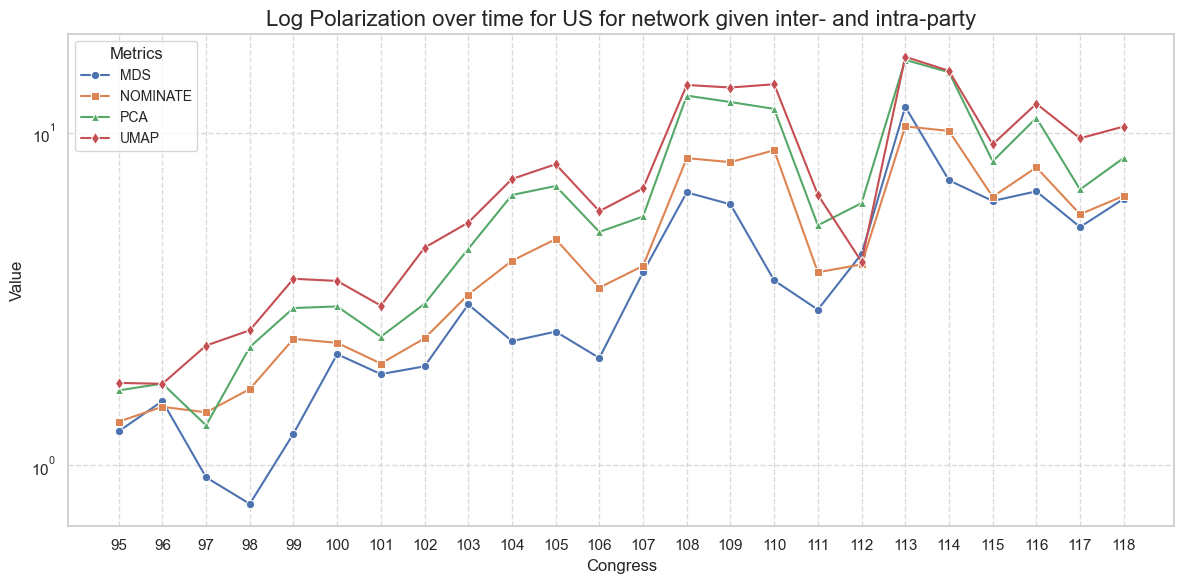

In [ ]:

results = pd.read_csv("data/USA/Micheles/results/polarization_scores.csv")
records = []
for congress, metrics in results.items():
    record = {'congress': congress}
    record.update(metrics)
    records.append(record)

# Create DataFrame and handle missing values
df = pd.DataFrame(records)
df = df.sort_values('congress')
df_transposed = df.set_index(df.columns[0]).T
#df_transposed.pop('congress')
df_transposed
# Assuming df_transposed is your DataFrame with columns: congress, mds, nominate, pca, umap
# and congress is the column to be used as x-axis

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the line plot
sns.lineplot(data=df_transposed, x='congress', y='mds', marker='o', label='MDS')
sns.lineplot(data=df_transposed, x='congress', y='nominate', marker='s', label='NOMINATE')
sns.lineplot(data=df_transposed, x='congress', y='pca', marker='^', label='PCA')
sns.lineplot(data=df_transposed, x='congress', y='umap', marker='d', label='UMAP')




# Customize the plot
plt.title("Log Polarization over time for US for network given inter- and intra-party", fontsize=16)
plt.xlabel('Congress', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Metrics', fontsize=10)
plt.yscale('log')

# Make sure x-axis shows integer values for Congress
plt.xticks(df_transposed['congress'])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()
plt.savefig("./images/US_polarization_Michheles_log.png", dpi=300)
# Show the plot
plt.show()


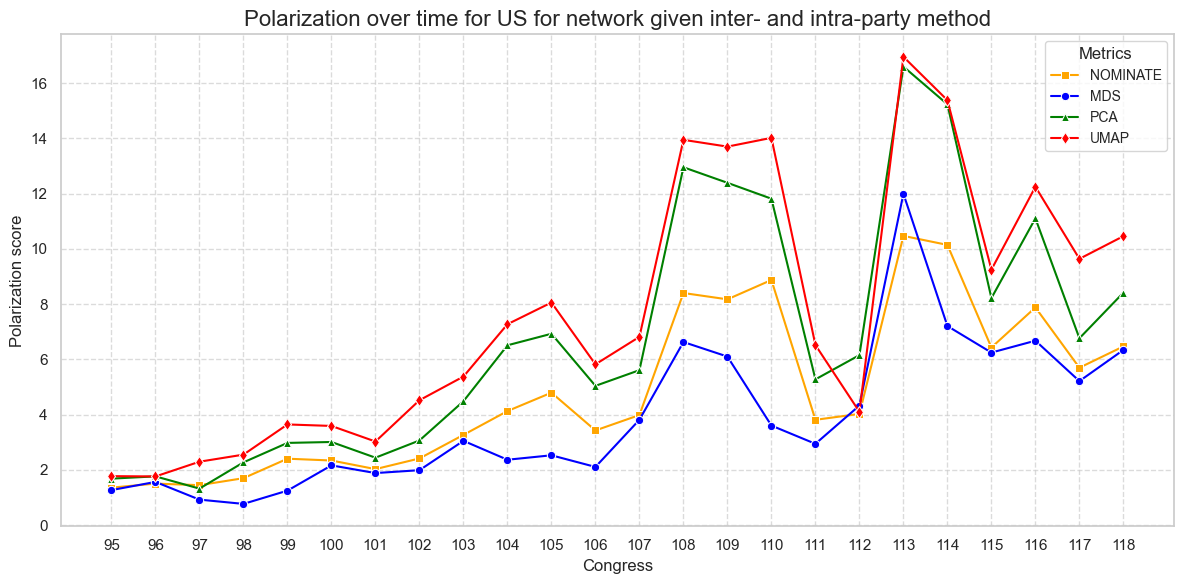

In [57]:

results = pd.read_csv("data/USA/Micheles/results/polarization_scores.csv")
records = []
for congress, metrics in results.items():
    record = {'congress': congress}
    record.update(metrics)
    records.append(record)

# Create DataFrame and handle missing values
df = pd.DataFrame(records)
df = df.sort_values('congress')
df_transposed = df.set_index(df.columns[0]).T
#df_transposed.pop('congress')
df_transposed
# Assuming df_transposed is your DataFrame with columns: congress, mds, nominate, pca, umap
# and congress is the column to be used as x-axis

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the line plot
sns.lineplot(data=df_transposed, x='congress', y='nominate', marker='s', label='NOMINATE', color='orange')
sns.lineplot(data=df_transposed, x='congress', y='mds', marker='o', label='MDS', color='blue')
sns.lineplot(data=df_transposed, x='congress', y='pca', marker='^', label='PCA', color='green')
sns.lineplot(data=df_transposed, x='congress', y='umap', marker='d', label='UMAP', color='red')




# Customize the plot
plt.title("Polarization over time for US for network given inter- and intra-party method", fontsize=16)
plt.xlabel('Congress', fontsize=12)
plt.ylabel('Polarization score', fontsize=12)
plt.legend(title='Metrics', fontsize=10)


# Make sure x-axis shows integer values for Congress
plt.xticks(df_transposed['congress'])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()
plt.savefig("./images/US_polarization_Michheles_nominate.png", dpi=300)
# Show the plot
plt.show()


In [ ]:
## Denmark
def D_analyze_polarization_across_congresses(congresses, data_path="data/Denmark/", output_path="data/Denmark/results/", 
                               methods=["pca", "mds", "umap"]):
    """
    Calculates and compares polarization across congresses using dimensionality reduction and NOMINATE scores.
    Uses pre-existing network edge lists created by construct_congress_network().
    
    Parameters:
    -----------
    congresses : list
        List of congress numbers (e.g., ['111', '112', '113'])
    data_path : str
        Path to the data directory
    output_path : str
        Path to save output files
    methods : list
        List of dimensionality reduction methods to use: 'pca', 'mds', 'umap'
        
    Returns:
    --------
    dict
        Dictionary containing polarization scores for each congress and method
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import networkx as nx
    import os
    from scipy.sparse import csr_matrix
    from sklearn.decomposition import PCA
    from sklearn.manifold import MDS
    import umap

    
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Dictionary to store polarization scores for each congress
    polarization_results = {}
    
    # Process each congress
    for congress in congresses:
        print(f"\nProcessing {congress}th Congress...")
        congress_polarization = {}
        
        try:
            # Step 1: Load the edge list for the network
            edge_file = f"{data_path}edgelist/P{congress}_DK_edgelist.csv"
            edge_df = pd.read_csv(edge_file)
            print(f"Loaded edge list for {congress}th Congress with {len(edge_df)} edges")
            
            # Clean up edge data - ensure numeric values
            edge_df = edge_df[pd.to_numeric(edge_df['Source'], errors='coerce').notna()]
            edge_df = edge_df[pd.to_numeric(edge_df['Target'], errors='coerce').notna()]
            
            # Convert to numeric and create graph
            edge_df['Source'] = edge_df['Source'].astype(int)
            edge_df['Target'] = edge_df['Target'].astype(int)
            G = nx.from_pandas_edgelist(edge_df, 'Source', 'Target')
            print(f"Created network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
            
            

            # Step 4: Load the voting data for dimensionality reduction
            votes_file = f"{data_path}Raw/P{congress}_DK.csv"
            votes_df = pd.read_csv(votes_file)
            print(f"Loaded {len(votes_df)} votes for {congress}th Congress")
            
            # Step 5: Create a sparse matrix of votes
            reps = votes_df['aktørid'].unique()
            roll_calls = votes_df['afstemningid'].unique()
            
            rep_to_idx = {rep: i for i, rep in enumerate(reps)}
            roll_to_idx = {roll: j for j, roll in enumerate(roll_calls)}
            
            row_indices = []
            col_indices = []
            values = []
            
            for _, row in votes_df.iterrows():
                rep_idx = rep_to_idx[row['aktørid']]
                roll_idx = roll_to_idx[row['afstemningid']]
                row_indices.append(rep_idx)
                col_indices.append(roll_idx)
                values.append(row['typeid_x'])
            
            # Create the sparse matrix
            sparse_matrix = csr_matrix((values, (row_indices, col_indices)), 
                                      shape=(len(reps), len(roll_calls)))
            
            # Create a DataFrame linking sparse matrix rows to representative IDs
            sparse_df = pd.DataFrame({'aktørid': reps})
            
            # Step 6: Perform dimensionality reduction for each method
            if 'pca' in methods:
                print("Performing PCA...")
                pca = PCA(n_components=2)
                pca_result = pca.fit_transform(sparse_matrix.toarray())
                sparse_df['pca_1'] = pca_result[:, 0]
                sparse_df['pca_2'] = pca_result[:, 1]
                
                # Calculate polarization using PCA
                sparse_df['aktørid'] = sparse_df['aktørid'].astype(int)
                pca_opinions = dict(zip(sparse_df['aktørid'], sparse_df['pca_1']))
                
                # Filter for nodes in the graph and valid values
                pca_opinions = {k: v for k, v in pca_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if pca_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(pca_opinions.values())
                    max_val = max(pca_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        pca_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in pca_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(pca_opinions_norm, {}, G)
                        congress_polarization['pca'] = pol_score
                        print(f"PCA polarization: {pol_score:.4f}")
            
            if 'mds' in methods:
                print("Performing MDS...")
                mds = MDS(n_components=2, random_state=42, n_jobs=-1)
                mds_result = mds.fit_transform(sparse_matrix.toarray())
                sparse_df['mds_1'] = mds_result[:, 0]
                sparse_df['mds_2'] = mds_result[:, 1]
                
                # Calculate polarization using MDS
                mds_opinions = dict(zip(sparse_df['aktørid'], sparse_df['mds_1']))
                
                # Filter for nodes in the graph and valid values
                mds_opinions = {k: v for k, v in mds_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if mds_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(mds_opinions.values())
                    max_val = max(mds_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        mds_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in mds_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(mds_opinions_norm, {}, G)
                        congress_polarization['mds'] = pol_score
                        print(f"MDS polarization: {pol_score:.4f}")
            
            if 'umap' in methods:
                print("Performing UMAP...")
                reducer = umap.UMAP(n_components=2, random_state=42)
                umap_result = reducer.fit_transform(sparse_matrix.toarray())
                sparse_df['umap_1'] = umap_result[:, 0]
                sparse_df['umap_2'] = umap_result[:, 1]
                
                # Calculate polarization using UMAP
                umap_opinions = dict(zip(sparse_df['aktørid'], sparse_df['umap_1']))
                
                # Filter for nodes in the graph and valid values
                umap_opinions = {k: v for k, v in umap_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if umap_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(umap_opinions.values())
                    max_val = max(umap_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        umap_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in umap_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(umap_opinions_norm, {}, G)
                        congress_polarization['umap'] = pol_score
                        print(f"UMAP polarization: {pol_score:.4f}")
            
            # Save results for this congress
            polarization_results[congress] = congress_polarization
            
            # Save the dimensionality reduction results for future use
            sparse_df.to_csv(f"{output_path}P{congress}_dimensionality_reduction.csv", index=False)
            
        except Exception as e:
            print(f"Error processing {congress}th Congress: {e}")
    
    # Plot the polarization scores if we have results
    if polarization_results:
        try:
            # Convert to DataFrame for easier plotting
            pol_df = pd.DataFrame.from_dict(polarization_results, orient='index')
            
            # Sort by congress number
            pol_df = pol_df.reset_index().rename(columns={'index': 'congress'})
            pol_df['congress_num'] = pol_df['congress'].astype(int)
            pol_df = pol_df.sort_values('congress_num').set_index('congress')
            pol_df = pol_df.drop('congress_num', axis=1)
            
            # Create the plot
            plt.figure(figsize=(12, 8))
            
            # Plot NOMINATE first
            if 'nominate' in pol_df.columns:
                plt.plot(pol_df.index, pol_df['nominate'], 'ko-', linewidth=2, markersize=8, label='NOMINATE')
            
            # Then each method with different styles
            styles = {
                'pca': ('bs--', 'blue', 'PCA'),
                'mds': ('rd--', 'red', 'MDS'),
                'umap': ('g^--', 'green', 'UMAP')
            }
            
            for method in methods:
                if method in pol_df.columns:
                    style, color, label = styles.get(method, ('o--', 'gray', method.upper()))
                    plt.plot(pol_df.index, pol_df[method], style, 
                            linewidth=1.5, markersize=8, label=label)
     
            
            
            # Save the data
            pol_df.to_csv(f"{output_path}polarization_scores.csv")
            print(f"Saved polarization data to {output_path}polarization_scores.csv")
            
        except Exception as e:
            print(f"Error creating polarization plot: {e}")
    
    return polarization_results

# Example usage:
# congresses = ['111', '112', '113', '114', '115', '116', '117']
# results = analyze_polarization_across_congresses(congresses, data_path="data/USA/", output_path="data/USA/results/")

In [ ]:
period = ['01_05','05_07','07_11','11_15','15_19','19_22', "22_present"]

In [ ]:
results = D_analyze_polarization_across_congresses(period, data_path="data/Denmark/", output_path="data/Denmark/results/")


Processing 01_05th Congress...
Loaded edge list for 01_05th Congress with 13994 edges
Created network with 187 nodes and 6997 edges
Loaded 29487 votes for 01_05th Congress
Performing PCA...
PCA polarization: 2.1729
Performing MDS...
MDS polarization: 1.7477
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 2.4077

Processing 05_07th Congress...
Loaded edge list for 05_07th Congress with 18118 edges
Created network with 215 nodes and 9059 edges
Loaded 135901 votes for 05_07th Congress
Performing PCA...
PCA polarization: 2.3456
Performing MDS...
MDS polarization: 2.2926
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 4.6746

Processing 07_11th Congress...
Loaded edge list for 07_11th Congress with 26414 edges
Created network with 238 nodes and 13207 edges
Loaded 187400 votes for 07_11th Congress
Performing PCA...
PCA polarization: 0.9816
Performing MDS...
MDS polarization: 1.0448
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 1.7470

Processing 11_15th Congress...
Loaded edge list for 11_15th Congress with 24816 edges
Created network with 226 nodes and 12408 edges
Loaded 183908 votes for 11_15th Congress
Performing PCA...
PCA polarization: 0.8483
Performing MDS...
MDS polarization: 0.9740
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 1.0748

Processing 15_19th Congress...
Loaded edge list for 15_19th Congress with 13480 edges
Created network with 230 nodes and 6740 edges
Loaded 208401 votes for 15_19th Congress
Performing PCA...
PCA polarization: 1.6356
Performing MDS...
MDS polarization: 1.5789
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 2.3617

Processing 19_22th Congress...
Loaded edge list for 19_22th Congress with 18402 edges
Created network with 216 nodes and 9201 edges
Loaded 164342 votes for 19_22th Congress
Performing PCA...
PCA polarization: 0.8583
Performing MDS...
MDS polarization: 0.9978
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 1.2107

Processing 22_presentth Congress...
Loaded edge list for 22_presentth Congress with 15830 edges
Created network with 223 nodes and 7915 edges
Loaded 116900 votes for 22_presentth Congress
Performing PCA...
PCA polarization: 1.4213
Performing MDS...
MDS polarization: 1.4255
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 1.2810
Error creating polarization plot: invalid literal for int() with base 10: '22_present'


In [ ]:
## Denmark
def DM_analyze_polarization_across_congresses(congresses, data_path="data/Denmark/", output_path="data/Denmark/results/", 
                               methods=["pca", "mds", "umap"]):
    """
    Calculates and compares polarization across congresses using dimensionality reduction and NOMINATE scores.
    Uses pre-existing network edge lists created by construct_congress_network().
    
    Parameters:
    -----------
    congresses : list
        List of congress numbers (e.g., ['111', '112', '113'])
    data_path : str
        Path to the data directory
    output_path : str
        Path to save output files
    methods : list
        List of dimensionality reduction methods to use: 'pca', 'mds', 'umap'
        
    Returns:
    --------
    dict
        Dictionary containing polarization scores for each congress and method
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import networkx as nx
    import os
    from scipy.sparse import csr_matrix
    from sklearn.decomposition import PCA
    from sklearn.manifold import MDS
    import umap
    from modules import ps
    
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Dictionary to store polarization scores for each congress
    polarization_results = {}
    
    # Process each congress
    for congress in congresses:
        print(f"\nProcessing {congress}th Congress...")
        congress_polarization = {}
        
        try:
            # Step 1: Load the edge list for the network
            edge_file = f"{data_path}Micheles/congress_{congress}_edges.csv"
            edge_df = pd.read_csv(edge_file)
            print(f"Loaded edge list for {congress}th Congress with {len(edge_df)} edges")
            
            # Clean up edge data - ensure numeric values
            edge_df = edge_df[pd.to_numeric(edge_df['Source'], errors='coerce').notna()]
            edge_df = edge_df[pd.to_numeric(edge_df['Target'], errors='coerce').notna()]
            
            # Convert to numeric and create graph
            edge_df['Source'] = edge_df['Source'].astype(int)
            edge_df['Target'] = edge_df['Target'].astype(int)
            G = nx.from_pandas_edgelist(edge_df, 'Source', 'Target')
            print(f"Created network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
            
            

            # Step 4: Load the voting data for dimensionality reduction
            votes_file = f"{data_path}Raw/P{congress}_DK.csv"
            votes_df = pd.read_csv(votes_file)
            print(f"Loaded {len(votes_df)} votes for {congress}th Congress")
            
            # Step 5: Create a sparse matrix of votes
            reps = votes_df['aktørid'].unique()
            roll_calls = votes_df['afstemningid'].unique()
            
            rep_to_idx = {rep: i for i, rep in enumerate(reps)}
            roll_to_idx = {roll: j for j, roll in enumerate(roll_calls)}
            
            row_indices = []
            col_indices = []
            values = []
            
            for _, row in votes_df.iterrows():
                rep_idx = rep_to_idx[row['aktørid']]
                roll_idx = roll_to_idx[row['afstemningid']]
                row_indices.append(rep_idx)
                col_indices.append(roll_idx)
                values.append(row['typeid_x'])
            
            # Create the sparse matrix
            sparse_matrix = csr_matrix((values, (row_indices, col_indices)), 
                                      shape=(len(reps), len(roll_calls)))
            
            # Create a DataFrame linking sparse matrix rows to representative IDs
            sparse_df = pd.DataFrame({'aktørid': reps})
            
            # Step 6: Perform dimensionality reduction for each method
            if 'pca' in methods:
                print("Performing PCA...")
                pca = PCA(n_components=2)
                pca_result = pca.fit_transform(sparse_matrix.toarray())
                sparse_df['pca_1'] = pca_result[:, 0]
                sparse_df['pca_2'] = pca_result[:, 1]
                
                # Calculate polarization using PCA
                sparse_df['aktørid'] = sparse_df['aktørid'].astype(int)
                pca_opinions = dict(zip(sparse_df['aktørid'], sparse_df['pca_1']))
                
                # Filter for nodes in the graph and valid values
                pca_opinions = {k: v for k, v in pca_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if pca_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(pca_opinions.values())
                    max_val = max(pca_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        pca_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in pca_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(pca_opinions_norm, {}, G)
                        congress_polarization['pca'] = pol_score
                        print(f"PCA polarization: {pol_score:.4f}")
            
            if 'mds' in methods:
                print("Performing MDS...")
                mds = MDS(n_components=2, random_state=42, n_jobs=-1)
                mds_result = mds.fit_transform(sparse_matrix.toarray())
                sparse_df['mds_1'] = mds_result[:, 0]
                sparse_df['mds_2'] = mds_result[:, 1]
                
                # Calculate polarization using MDS
                mds_opinions = dict(zip(sparse_df['aktørid'], sparse_df['mds_1']))
                
                # Filter for nodes in the graph and valid values
                mds_opinions = {k: v for k, v in mds_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if mds_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(mds_opinions.values())
                    max_val = max(mds_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        mds_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in mds_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(mds_opinions_norm, {}, G)
                        congress_polarization['mds'] = pol_score
                        print(f"MDS polarization: {pol_score:.4f}")
            
            if 'umap' in methods:
                print("Performing UMAP...")
                reducer = umap.UMAP(n_components=2, random_state=42)
                umap_result = reducer.fit_transform(sparse_matrix.toarray())
                sparse_df['umap_1'] = umap_result[:, 0]
                sparse_df['umap_2'] = umap_result[:, 1]
                
                # Calculate polarization using UMAP
                umap_opinions = dict(zip(sparse_df['aktørid'], sparse_df['umap_1']))
                
                # Filter for nodes in the graph and valid values
                umap_opinions = {k: v for k, v in umap_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if umap_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(umap_opinions.values())
                    max_val = max(umap_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        umap_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in umap_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(umap_opinions_norm, {}, G)
                        congress_polarization['umap'] = pol_score
                        print(f"UMAP polarization: {pol_score:.4f}")
            
            # Save results for this congress
            polarization_results[congress] = congress_polarization
            
            # Save the dimensionality reduction results for future use
            sparse_df.to_csv(f"{output_path}P{congress}_dimensionality_reduction.csv", index=False)
            
        except Exception as e:
            print(f"Error processing {congress}th Congress: {e}")
    
    # Plot the polarization scores if we have results
    if polarization_results:
        try:
            
            plt.savefig(f"{output_path}polarization_over_time.png", dpi=300)
            print(f"Saved polarization plot to {output_path}polarization_over_time.png")
            
            # Also save the plot with a timestamp for easy reference
            import datetime
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            plt.savefig(f"{output_path}polarization_over_time_{timestamp}.png", dpi=300)
            
        except Exception as e:
            print(f"Error creating polarization plot: {e}")
    
    return polarization_results

# Example usage:
# congresses = ['111', '112', '113', '114', '115', '116', '117']
# results = analyze_polarization_across_congresses(congresses, data_path="data/USA/", output_path="data/USA/results/")

In [ ]:
results = DM_analyze_polarization_across_congresses(period, data_path="./data/Denmark/", output_path="./data/Denmark/Micheles/results/")


Processing 01_05th Congress...
Loaded edge list for 01_05th Congress with 2702 edges
Created network with 108 nodes and 2702 edges
Loaded 29487 votes for 01_05th Congress
Performing PCA...
PCA polarization: 7.8369
Performing MDS...
MDS polarization: 4.0812
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 6.8128

Processing 05_07th Congress...
Loaded edge list for 05_07th Congress with 4358 edges
Created network with 138 nodes and 4358 edges
Loaded 135901 votes for 05_07th Congress
Performing PCA...
PCA polarization: 1.9770
Performing MDS...
MDS polarization: 1.6886
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 2.5642

Processing 07_11th Congress...
Loaded edge list for 07_11th Congress with 4908 edges
Created network with 148 nodes and 4908 edges
Loaded 187400 votes for 07_11th Congress
Performing PCA...
PCA polarization: 1.9269
Performing MDS...
MDS polarization: 1.9443
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 1.7841

Processing 11_15th Congress...
Loaded edge list for 11_15th Congress with 4852 edges
Created network with 152 nodes and 4852 edges
Loaded 183908 votes for 11_15th Congress
Performing PCA...
PCA polarization: 1.7846
Performing MDS...
MDS polarization: 1.7879
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 2.4112

Processing 15_19th Congress...
Loaded edge list for 15_19th Congress with 3956 edges
Created network with 144 nodes and 3956 edges
Loaded 208401 votes for 15_19th Congress
Performing PCA...
PCA polarization: 2.7317
Performing MDS...
MDS polarization: 2.1700
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 3.5918

Processing 19_22th Congress...
Loaded edge list for 19_22th Congress with 4194 edges
Created network with 139 nodes and 4194 edges
Loaded 164342 votes for 19_22th Congress
Performing PCA...
PCA polarization: 1.9038
Performing MDS...
MDS polarization: 2.1069
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 2.4013

Processing 22_presentth Congress...
Loaded edge list for 22_presentth Congress with 4254 edges
Created network with 147 nodes and 4254 edges
Loaded 116900 votes for 22_presentth Congress
Performing PCA...
PCA polarization: 2.2669
Performing MDS...
MDS polarization: 2.0147
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 2.1697
Saved polarization plot to ./data/Denmark/Micheles/results/polarization_over_time.png


<Figure size 640x480 with 0 Axes>

In [ ]:
#edgelist creation

# import pandas as pd
# import numpy as np
# import utils
# D_data = pd.read_csv('data/Denmark/period_2022_present.csv')
# D_PA, D_PAV, D_PAVP, D_PP = utils.dict_create(D_data, 'aktørid','party','afstemningid','typeid_x')
# D_thres = np.average(utils.calc_thres(D_PP,D_PA,D_PAV))
# edgelist = utils.edgelist_calc(D_PA,D_PAV, D_thres)
# df = pd.DataFrame(edgelist, columns=["Source", "Target"])
# df.to_csv("data/Denmark/edgelist/P22_present_DK_edgelist.csv", index=False)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

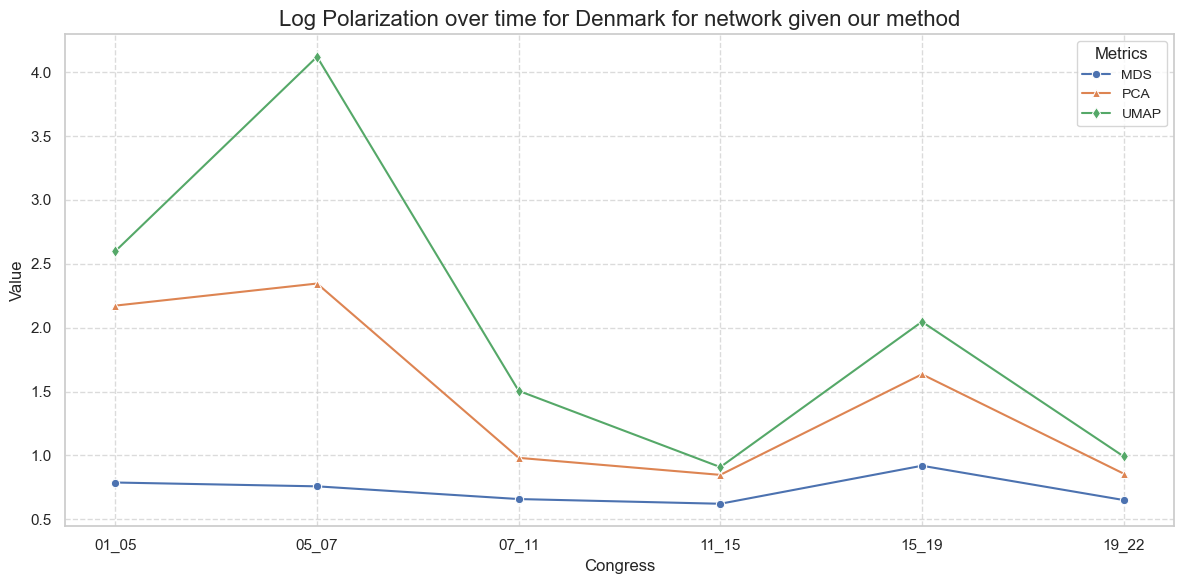

In [ ]:
results = pd.read_csv("data/Denmark/results/polarization_scores.csv")
records = []
for congress, metrics in results.items():
    record = {'congress': congress}
    record.update(metrics)
    records.append(record)

# Create DataFrame and handle missing values
df = pd.DataFrame(records)
df = df.sort_values('congress')
df_transposed = df.set_index(df.columns[0]).T
#df_transposed.pop('congress')
df_transposed
# Assuming df_transposed is your DataFrame with columns: congress, mds, nominate, pca, umap
# and congress is the column to be used as x-axis

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the line plot
sns.lineplot(data=df_transposed, x='congress', y='mds', marker='o', label='MDS')
sns.lineplot(data=df_transposed, x='congress', y='pca', marker='^', label='PCA')
sns.lineplot(data=df_transposed, x='congress', y='umap', marker='d', label='UMAP')




# Customize the plot
plt.title('Log Polarization over time for Denmark for network given our method', fontsize=16)
plt.xlabel('Congress', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Metrics', fontsize=10)
plt.yscale('log')

# Make sure x-axis shows integer values for Congress
plt.xticks(df_transposed['congress'])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()
plt.savefig("./images/DK_polarization_our_log.png", dpi=300)
# Show the plot
plt.show()

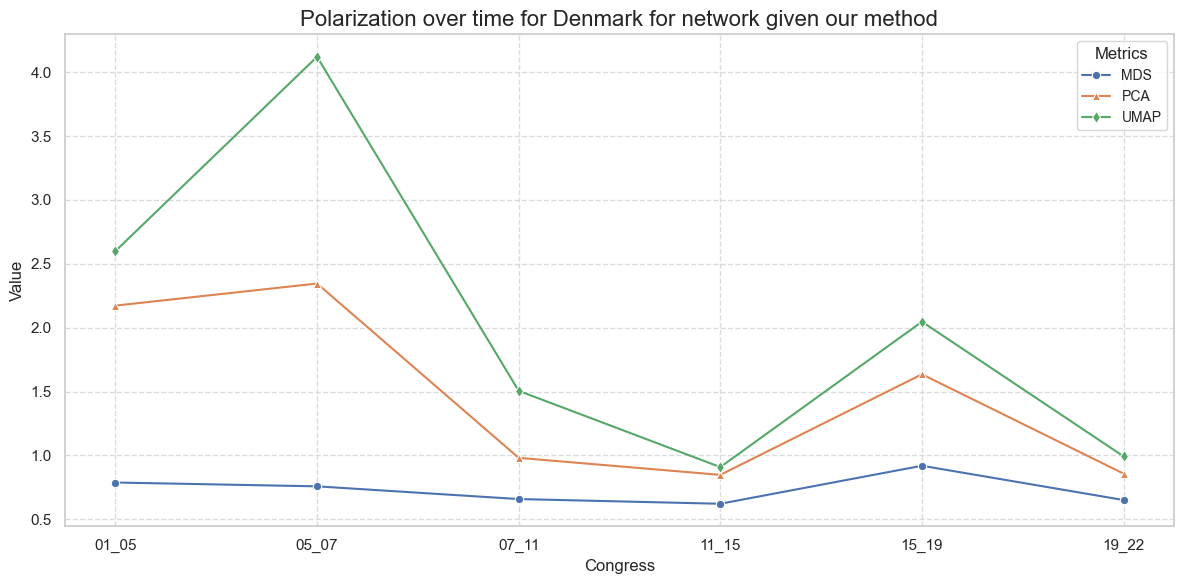

In [ ]:
results = pd.read_csv("data/Denmark/results/polarization_scores.csv")
records = []
for congress, metrics in results.items():
    record = {'congress': congress}
    record.update(metrics)
    records.append(record)

# Create DataFrame and handle missing values
df = pd.DataFrame(records)
df = df.sort_values('congress')
df_transposed = df.set_index(df.columns[0]).T
#df_transposed.pop('congress')
df_transposed
# Assuming df_transposed is your DataFrame with columns: congress, mds, nominate, pca, umap
# and congress is the column to be used as x-axis

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the line plot
sns.lineplot(data=df_transposed, x='congress', y='mds', marker='o', label='MDS')
sns.lineplot(data=df_transposed, x='congress', y='pca', marker='^', label='PCA')
sns.lineplot(data=df_transposed, x='congress', y='umap', marker='d', label='UMAP')




# Customize the plot
plt.title('Polarization over time for Denmark for network given our method', fontsize=16)
plt.xlabel('Congress', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Metrics', fontsize=10)


# Make sure x-axis shows integer values for Congress
plt.xticks(df_transposed['congress'])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()
plt.savefig("./images/DK_polarization_our.png", dpi=300)
# Show the plot
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

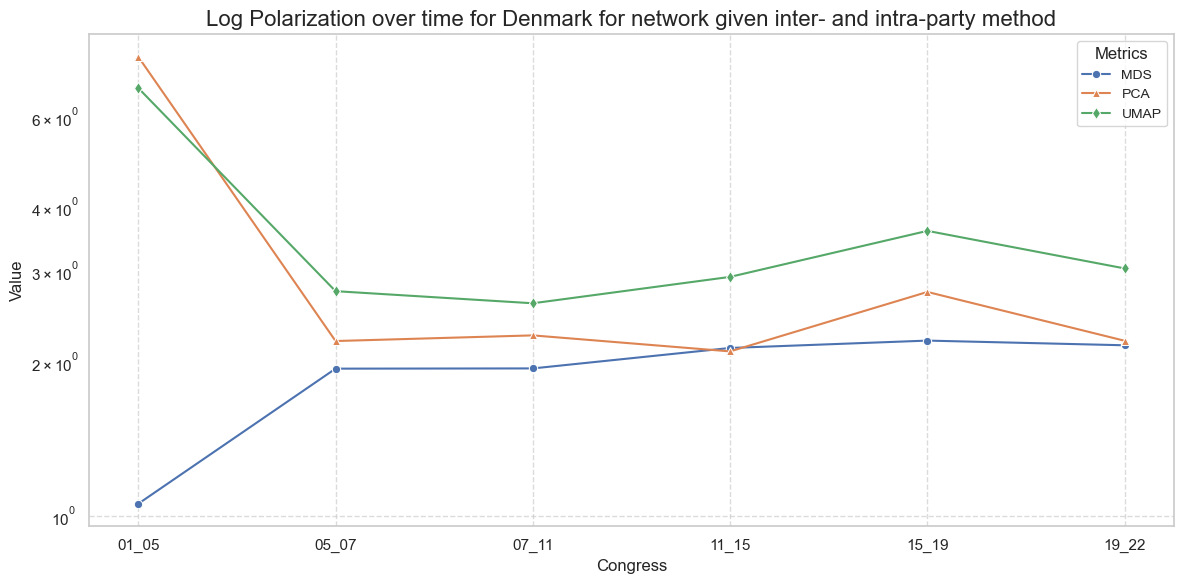

In [3]:
results = pd.read_csv("data/Denmark/Micheles/results/polarization_scores.csv")
records = []
for congress, metrics in results.items():
    record = {'congress': congress}
    record.update(metrics)
    records.append(record)

# Create DataFrame and handle missing values
df = pd.DataFrame(records)
df = df.sort_values('congress')
df_transposed = df.set_index(df.columns[0]).T
#df_transposed.pop('congress')
df_transposed
# Assuming df_transposed is your DataFrame with columns: congress, mds, nominate, pca, umap
# and congress is the column to be used as x-axis

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the line plot
sns.lineplot(data=df_transposed, x='congress', y='mds', marker='o', label='MDS')
sns.lineplot(data=df_transposed, x='congress', y='pca', marker='^', label='PCA')
sns.lineplot(data=df_transposed, x='congress', y='umap', marker='d', label='UMAP')



# Customize the plot
plt.title('Log Polarization over time for Denmark for network given inter- and intra-party method', fontsize=16)
plt.xlabel('Congress', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Metrics', fontsize=10)
plt.yscale('log')
# Make sure x-axis shows integer values for Congress
plt.xticks(df_transposed['congress'])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()
plt.savefig("./images/DK_polarization_Michheles_log.png", dpi=300)
# Show the plot
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


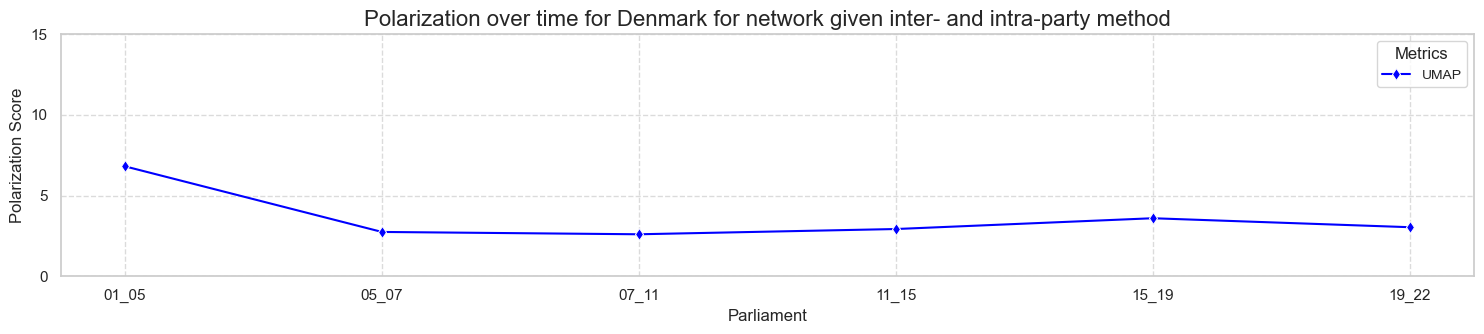

In [80]:
results = pd.read_csv("data/Denmark/Micheles/results/polarization_scores.csv")
records = []
for congress, metrics in results.items():
    record = {'congress': congress}
    record.update(metrics)
    records.append(record)

# Create DataFrame and handle missing values
df = pd.DataFrame(records)

'''
df.insert(loc=1, column='84_87', value=['84_87',1,1,np.nan])
df.insert(loc=2, column='87_88', value=['87_88',1,1,np.nan])
df.insert(loc=3, column='88_90', value=['88_90',1,1,np.nan])
df.insert(loc=4, column='90_94', value=['90_94',1,1,np.nan])
df.insert(loc=5, column='94_98', value=['94_98',1,1,np.nan])
df.insert(loc=6, column='98_01', value=['98_01',1,1,np.nan])
'''

df = df.sort_values('congress')


df_transposed = df.set_index(df.columns[0]).T
#df_transposed.pop('congress')

df_transposed
# Assuming df_transposed is your DataFrame with columns: congress, mds, nominate, pca, umap
# and congress is the column to be used as x-axis

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 3.5))

# Create the line plot
#sns.lineplot(data=df_transposed, x='congress', y='mds', marker='o', label='MDS', color='blue')
#sns.lineplot(data=df_transposed, x='congress', y='pca', marker='^', label='PCA', color='green')
sns.lineplot(data=df_transposed, x='congress', y='umap', marker='d', label='UMAP', color='blue')



# Customize the plot
plt.title('Polarization over time for Denmark for network given inter- and intra-party method', fontsize=16)
plt.xlabel('Parliament', fontsize=12)
plt.ylabel('Polarization Score', fontsize=12)
plt.legend(title='Metrics', fontsize=10)
# Make sure x-axis shows integer values for Congress
plt.xticks(df_transposed['congress'])
plt.yticks([0,5,10,15])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()
plt.savefig("./images/DK_polarization_Michheles.png", dpi=300)
# Show the plot
plt.show()

In [66]:
df 

,congress,95_98,98_01,0,1,2,3,4,5
0,congress,98_01,98_01,01_05,05_07,07_11,11_15,15_19,19_22
2,mds,1,1,1.057142,1.93691,1.938907,2.124965,2.196394,2.150741
1,pca,1,1,7.83685,2.192103,2.248349,2.092688,2.731673,2.194592
3,umap,NaN,NaN,6.812753,2.741074,2.596351,2.922344,3.591778,3.035056
